In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import std, mean
import pickle 
import os
import joblib

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, jaccard_score, cohen_kappa_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,balanced_accuracy_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import torch
from torch import nn

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
def plot_confusion_matrix_multiclass(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Plot a confusion matrix for multi-class classification.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) labels.
    y_pred : array-like of shape (n_samples,)
        Predicted labels, as returned by a classifier.
    labels : list, optional
        List of label names (e.g. [0, 1, 2, ...]).
        If None, the labels are inferred from the data.
    title : str, optional
        Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    plt.tight_layout()
    plt.show()

In [3]:
def plot_roc_auc_multiclass(y_true, y_score, classes, title="ROC Curves (One-vs-Rest)"):
    """
    Plot multi-class ROC curves using one-vs-rest approach.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) labels, as integers from 0..(n_classes-1).
    y_score : array-like of shape (n_samples, n_classes)
        Predicted probabilities (or scores) for each class.
    classes : str
        Name of classes.
    title : str, optional
        Title of the plot.
    """

    # Binarize the true labels for ROC computation
    # If the data is already one-hot or binary, skip this step.
    y_true_binarized = label_binarize(y_true, classes=classes)
    n_classes = len(classes)

    # For each class, compute ROC curve and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    # First aggregate all FPRs
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all TPRs at this FPR points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot
    plt.figure(figsize=(8, 6))

    # Plot each class's ROC
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i in range(n_classes):
        plt.plot(
            fpr[i], tpr[i],
            label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})",
            lw=2,
            color=colors(i)
        )

    # Plot micro-average
    plt.plot(
        fpr["micro"], tpr["micro"],
        label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
        color='deeppink', linestyle=':', linewidth=2
    )

    # Plot macro-average
    plt.plot(
        fpr["macro"], tpr["macro"],
        label=f"Macro-average (AUC = {roc_auc['macro']:.2f})",
        color='navy', linestyle=':', linewidth=2
    )

    # Random chance line
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [4]:
def evaluate_model(grid_search_cv, X_test, y_test):
    """
    Evaluates the performance of a trained GridSearchCV model on test data.
    
    Args:
        grid_search_cv (GridSearchCV): A trained GridSearchCV model.
        X_test (pd.DataFrame or np.ndarray): Test data features.
        y_test (pd.Series or np.ndarray): True labels for the test data.
        
    Returns:
        dict: A dictionary containing various evaluation metrics.
    """
    # Make predictions with the best estimator from the GridSearchCV
    best_model = grid_search_cv.best_estimator_
    y_pred = best_model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Accuracy
    bal_accuracy = balanced_accuracy_score(y_test, y_pred)
    print("Balanced Accuracy:", bal_accuracy)

    # Jaccard Score
    jaccard = jaccard_score(y_test, y_pred, average='macro')
    print("Jaccard Score:", jaccard)

    # Cohen’s Kappa Score
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Cohen Kappa Score:", kappa)

    # Precision, Recall, F1-Score
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall/Sensitivity (Macro): {recall:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")

    # Classification Report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Compute Specificity & Sensitivity (Recall) for each class
    cm = confusion_matrix(y_test, y_pred)
    specificity_per_class = {}
    sensitivity_per_class = {}

    unique_classes = np.unique(y_test)
    for i, label in enumerate(unique_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tp = cm[i, i]

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # This is Recall for the specific class

        specificity_per_class[label] = specificity
        sensitivity_per_class[label] = sensitivity

    print("\nSpecificity per class:", specificity_per_class)
    print("Sensitivity (Recall) per class:", sensitivity_per_class)

    return {
        "accuracy": accuracy,
        "balanced_accuracy": bal_accuracy,
        "jaccard": jaccard,
        "kappa": kappa,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
        "specificity_per_class": specificity_per_class,
        "sensitivity_per_class": sensitivity_per_class
    }

In [5]:
activation_dataset = pd.read_csv("DataFrames/activations.csv",header=[0, 1], index_col = 0)
activation_dataset

Model                    EfficientNetB4                                  \
Label                               MEL         NV        BCC        AK   
image                                                                     
ISIC_0064267                   2.665753  -5.085890   1.161175 -2.240161   
ISIC_0025587                   0.995228   5.375360  -4.511549 -2.484319   
ISIC_0053558                  -3.349179   0.019188   6.734812 -2.172287   
ISIC_0033796                   1.018768  12.193782 -10.183492 -8.544868   
ISIC_0013443_downsampled       0.128285  -2.644589  -4.963271 -2.801584   
...                                 ...        ...        ...       ...   
ISIC_0060089                   4.977726   6.496384  -3.091330 -4.423696   
ISIC_0071023                  -3.433354  -1.408838  -2.205017  3.294084   
ISIC_0070519                   0.730337   8.652523  -2.197978 -6.155305   
ISIC_0012256_downsampled       1.506777   4.547263  -3.907858 -5.996882   
ISIC_0073208                   2.706540  10.656256  -6.075733 -6.254128   

Model                                                              \
Label                           BKL        DF      VASC       SCC   
image                                                               
ISIC_0064267              -0.888061 -3.460177 -4.819719  9.805281   
ISIC_0025587               1.739991 -3.605157 -1.792029 -4.794184   
ISIC_0053558               2.733889 -2.726850 -3.659591 -0.431506   
ISIC_0033796               3.978828 -4.459220 -3.726934 -6.950730   
ISIC_0013443_downsampled  16.827974 -8.155312 -6.303571 -4.831725   
...                             ...       ...       ...       ...   
ISIC_0060089              -2.013051 -2.906393 -2.715396 -7.248559   
ISIC_0071023               2.907742 -2.758142 -3.834920  8.495058   
ISIC_0070519              -2.404502 -2.597361 -1.719250 -4.601078   
ISIC_0012256_downsampled   5.164260 -1.158894 -4.792548 -6.167954   
ISIC_0073208              -4.054747 -4.803928 -3.547509 -3.184748   

Model                    EfficientNetB5             ...  Resnext50             \
Label                               MEL         NV  ...       VASC        SCC   
image                                               ...                         
ISIC_0064267                  -2.688719  -4.488446  ... -13.230649   9.580107   
ISIC_0025587                   1.378499   8.048905  ...  -4.313031  -6.392378   
ISIC_0053558                  -0.507975  -2.487625  ... -20.934998  -3.637779   
ISIC_0033796                   2.284262  12.070561  ...  -8.939124  -7.203101   
ISIC_0013443_downsampled       0.497101   1.317666  ... -17.103924  -4.527175   
...                                 ...        ...  ...        ...        ...   
ISIC_0060089                   4.807579   8.080152  ... -10.532364 -16.043514   
ISIC_0071023                  -0.179236  -4.308942  ... -15.263538   9.401895   
ISIC_0070519                   3.107866  10.912735  ... -10.378563 -10.835146   
ISIC_0012256_downsampled       2.480339   5.460518  ...  -6.804214 -20.071964   
ISIC_0073208                   1.961226   6.989289  ...  -9.521125 -14.552724   

Model                    Resnet152                                             \
Label                          MEL        NV        BCC         AK        BKL   
image                                                                           
ISIC_0064267             -0.396588 -6.098094   3.730045   4.038379   1.769362   
ISIC_0025587              1.129915  3.737605  -6.615074  -5.739520   0.348753   
ISIC_0053558             -0.064949 -4.579978  11.552617  -6.213246  -1.829183   
ISIC_0033796              0.486007  6.627979 -11.357134  -9.202570  -0.288119   
ISIC_0013443_downsampled  3.634953  2.164896  -5.171359 -11.331422   8.291077   
...                            ...       ...        ...        ...        ...   
ISIC_0060089              5.825468  4.134807  -5.277250 -12.716278  -2.072538   
ISIC_0071023             -1.537480 -9

In [6]:
probability_dataset = pd.read_csv("DataFrames/probabilities.csv",header=[0, 1], index_col = 0)
probability_dataset

Model                    EfficientNetB4                              \
Label                               MEL            NV           BCC   
image                                                                 
ISIC_0064267               7.923343e-04  3.407318e-07  1.759861e-04   
ISIC_0025587               1.203890e-02  9.612887e-01  4.886789e-05   
ISIC_0053558               4.090123e-05  1.187407e-03  9.798463e-01   
ISIC_0033796               1.401618e-05  9.997154e-01  1.912273e-10   
ISIC_0013443_downsampled   5.590065e-08  3.492791e-09  3.437026e-10   
...                                 ...           ...           ...   
ISIC_0060089               1.795896e-01  8.200235e-01  5.622571e-05   
ISIC_0071023               6.539036e-06  4.951645e-05  2.233436e-05   
ISIC_0070519               3.624476e-04  9.995560e-01  1.938628e-05   
ISIC_0012256_downsampled   1.645930e-02  3.442528e-01  7.325970e-05   
ISIC_0073208               3.526372e-04  9.996449e-01  5.410474e-08   

Model                                                               \
Label                               AK           BKL            DF   
image                                                                
ISIC_0064267              5.865391e-06  2.267286e-05  1.731612e-06   
ISIC_0025587              3.710552e-04  2.535324e-02  1.209665e-04   
ISIC_0053558              1.326949e-04  1.792995e-02  7.620976e-05   
ISIC_0033796              9.844521e-10  2.705001e-04  5.855576e-08   
ISIC_0013443_downsampled  2.985321e-09  1.000000e+00  1.412202e-11   
...                                ...           ...           ...   
ISIC_0060089              1.483528e-05  1.652819e-04  6.764752e-05   
ISIC_0071023              5.460130e-03  3.710364e-03  1.284559e-05   
ISIC_0070519              3.705520e-07  1.576891e-05  1.300303e-05   
ISIC_0012256_downsampled  9.070133e-06  6.380228e-01  1.144789e-03   
ISIC_0073208              4.526470e-08  4.082617e-07  1.930070e-07   

Model                                                EfficientNetB5  \
Label                             VASC           SCC            MEL   
image                                                                 
ISIC_0064267              4.446405e-07  9.990007e-01   5.630129e-07   
ISIC_0025587              7.414747e-04  3.683638e-05   1.260459e-03   
ISIC_0053558              2.998651e-05  7.565988e-04   2.129783e-04   
ISIC_0033796              1.217859e-07  4.847529e-09   5.616233e-05   
ISIC_0013443_downsampled  8.996989e-11  3.920238e-10   5.444964e-06   
...                                ...           ...            ...   
ISIC_0060089              8.188442e-05  8.799807e-07   3.651605e-02   
ISIC_0071023              4.376387e-06  9.907340e-01   1.043997e-05   
ISIC_0070519              3.128985e-05  1.753240e-06   4.075759e-04   
ISIC_0012256_downsampled  3.024471e-05  7.643954e-06   2.322519e-02   
ISIC_0073208              6.779996e-07  9.744832e-07   6.502025e-03   

Model                                   ...     Resnext50                \
Label                               NV  ...          VASC           SCC   
image                                   ...                               
ISIC_0064267              9.309095e-08  ...  1.235656e-10  9.965141e-01   
ISIC_0025587              9.941443e-01  ...  6.996904e-05  8.746960e-06   
ISIC_0053558              2.941604e-05  ...  4.540916e-18  1.476491e-10   
ISIC_0033796              9.990350e-01  ...  4.194294e-08  2.380149e-07   
ISIC_0013443_downsampled  1.236978e-05  ...  1.207920e-12  3.499865e-07   
...                                ...  ...           ...           ...   
ISIC_0060089              9.632616e-01  ...  1.240162e-08  5.012061e-11   
ISIC_0071023              1.679542e-07  ...  1.931871e-11  9.954950e-01   
ISIC_0070519              9.995854e-01  ...  7.930507e-08  5.023536e-08   
ISIC_0012256_downsampled  4.573350e-01  ...  3.013001e-09  5.210613e-15   
ISIC_0073208              9.924508e-01  ...  1.063523e

In [7]:
ISIC = pd.read_csv("DataFrames/label.csv", index_col = 'image')
ISIC = ISIC.idxmax(axis=1)
ISIC.name = 'label'
ISIC

image
ISIC_0000000     NV
ISIC_0000001     NV
ISIC_0000002    MEL
ISIC_0000003     NV
ISIC_0000004    MEL
               ... 
ISIC_0073247    BCC
ISIC_0073248    BKL
ISIC_0073249    MEL
ISIC_0073251     NV
ISIC_0073254    BKL
Name: label, Length: 25331, dtype: object

In [8]:
metadata = pd.read_csv("DataFrames/ISIC_2019_Training_Metadata.csv", index_col = 'image')
metadata = metadata.drop(columns= 'lesion_id')
metadata.age_approx = metadata.age_approx / 100 #scaling the feature
metadata

,age_approx,anatom_site_general,sex
image,,,
ISIC_0000000,0.55,anterior torso,female
ISIC_0000001,0.30,anterior torso,female
ISIC_0000002,0.60,upper extremity,female
ISIC_0000003,0.30,upper extremity,male
ISIC_0000004,0.80,posterior torso,male
...,...,...,...
ISIC_0073247,0.85,head/neck,female
ISIC_0073248,0.65,anterior torso,male
ISIC_0073249,0.70,lower extremity,male


## Majority Vote

In [9]:
max_class_per_model = probability_dataset.T.groupby(level=0).idxmax()
max_class_per_model = max_class_per_model.T.map(lambda x: x[1] if isinstance(x, tuple) else x)
most_common_classes = max_class_per_model.mode(axis=1)[0]
most_common_classes.name = 'mode'

In [10]:
majority_vote = most_common_classes.to_frame().join(ISIC.to_frame())
majority_vote = majority_vote.dropna()

Classification Report:
              precision    recall  f1-score   support

          AK       0.72      0.82      0.77       865
         BCC       0.91      0.94      0.92      3323
         BKL       0.87      0.84      0.85      2624
          DF       0.90      0.87      0.89       239
         MEL       0.90      0.78      0.83      4520
          NV       0.92      0.96      0.94     12875
         SCC       0.86      0.78      0.82       628
        VASC       0.93      0.97      0.95       253

    accuracy                           0.90     25327
   macro avg       0.88      0.87      0.87     25327
weighted avg       0.90      0.90      0.90     25327

Confusion Matrix:


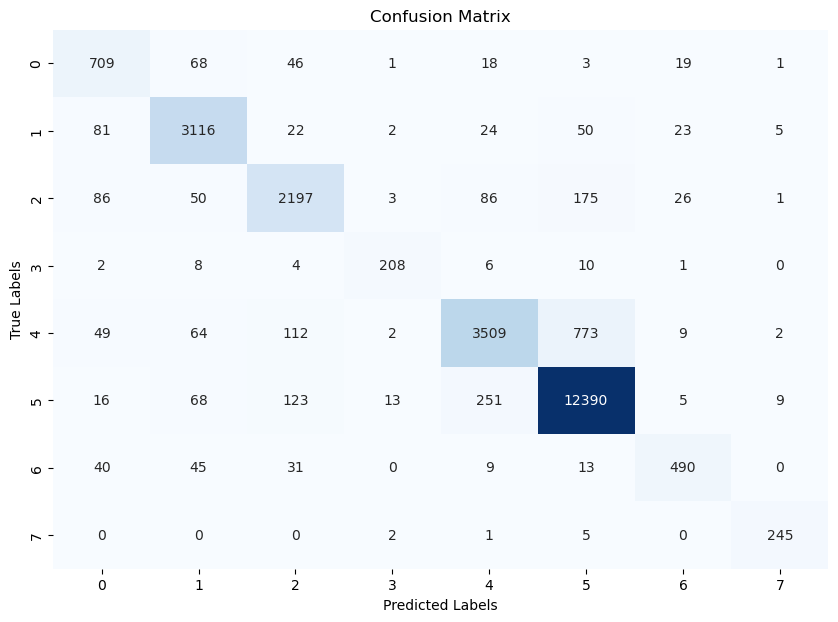

Balanced Accuracy:
0.8690270066840948


In [11]:
y_true = majority_vote.label.values
y_pred = majority_vote['mode'].values

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print the balanced accuracy
print("Balanced Accuracy:")
print(balanced_accuracy_score(y_true, y_pred))

## Mean Probability

In [12]:
probability_grouped = probability_dataset.groupby(axis=1, level=1).mean()
probability_grouped

/tmp/ipykernel_1231379/3422356072.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  probability_grouped = probability_dataset.groupby(axis=1, level=1).mean()


Label,AK,BCC,BKL,DF,MEL,NV,SCC,VASC
image,,,,,,,,
ISIC_0064267,0.044848,3.365531e-02,0.004697,6.894570e-07,0.000704,0.000002,9.160930e-01,1.164391e-07
ISIC_0025587,0.000161,5.687166e-04,0.013763,6.273839e-05,0.018056,0.966741,1.702842e-04,4.771942e-04
ISIC_0053558,0.000114,9.829961e-01,0.013755,1.695136e-05,0.002678,0.000244,1.873286e-04,9.064983e-06
ISIC_0033796,0.000020,2.924604e-06,0.006932,7.156195e-06,0.000530,0.992503,8.304618e-07,3.826351e-06
ISIC_0013443_downsampled,0.000120,2.991344e-07,0.997522,4.712544e-07,0.001909,0.000447,8.775161e-07,9.944463e-08
...,...,...,...,...,...,...,...,...
ISIC_0060089,0.000004,3.122528e-05,0.000211,2.005131e-05,0.237733,0.761980,6.955449e-07,1.946496e-05
ISIC_0071023,0.033409,3.309240e-03,0.001090,3.533736e-06,0.000013,0.000128,9.620447e-01,2.643640e-06
ISIC_0070519,0.000001,4.458100e-04,0.003172,1.819022e-05,0.113258,0.883082,4.575418e-06,1.828888e-05


In [13]:
mean_prediction = probability_grouped.idxmax(axis=1)
mean_prediction.name = 'mean'

/tmp/ipykernel_1231379/3402915190.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  mean_prediction = probability_grouped.idxmax(axis=1)


In [14]:
mean_prediction = mean_prediction.to_frame().join(ISIC.to_frame())
mean_prediction = mean_prediction.dropna()

Classification Report:
              precision    recall  f1-score   support

          AK       0.76      0.81      0.78       865
         BCC       0.92      0.94      0.93      3323
         BKL       0.89      0.84      0.86      2624
          DF       0.91      0.88      0.89       239
         MEL       0.90      0.79      0.84      4520
          NV       0.92      0.97      0.94     12875
         SCC       0.84      0.81      0.83       628
        VASC       0.92      0.97      0.95       253

    accuracy                           0.91     25327
   macro avg       0.88      0.88      0.88     25327
weighted avg       0.91      0.91      0.91     25327

Confusion Matrix:


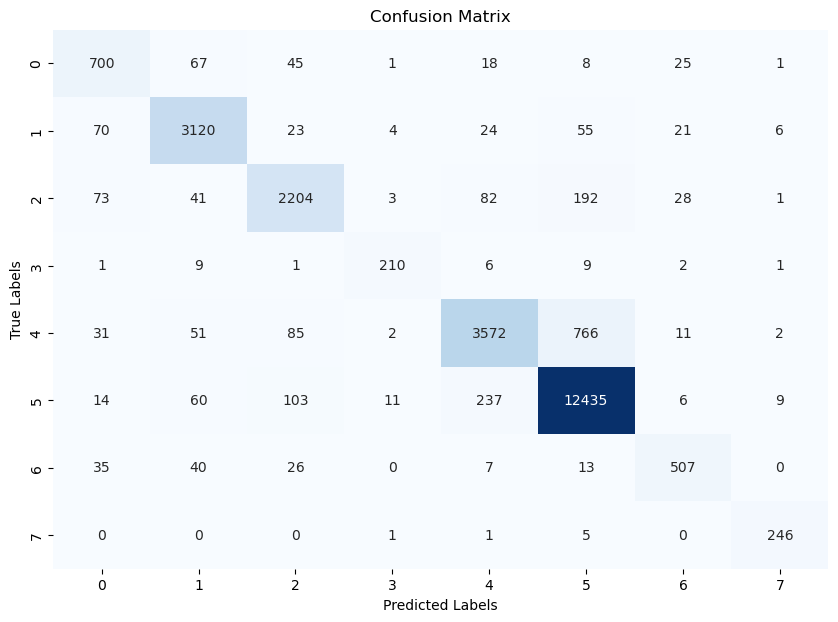

Balanced Accuracy:
0.8753133595149315


In [15]:
y_true = mean_prediction.label.values
y_pred = mean_prediction['mean'].values

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print the balanced accuracy
print("Balanced Accuracy:")
print(balanced_accuracy_score(y_true, y_pred))

# Meta Classification

In [16]:
activation_dataset.describe()

Model EfficientNetB4                                                          \
Label            MEL            NV           BCC            AK           BKL   
count   25327.000000  25327.000000  25327.000000  25327.000000  25327.000000   
mean        1.701171      5.288015     -2.477121     -4.031252     -0.578369   
std         4.720400      6.652758      5.966510      4.257900      4.534962   
min       -20.089367    -17.137040    -17.346445    -18.201405    -13.614973   
25%        -1.585002     -0.392698     -6.657465     -6.792105     -3.525662   
50%         0.995908      6.319669     -3.829335     -4.708287     -1.289571   
75%         4.458375     10.800401      0.058320     -2.084848      1.399742   
max        19.873295     27.139952     18.232950     28.295872     23.125170   

Model                                           EfficientNetB5                \
Label            DF          VASC           SCC            MEL            NV   
count  25327.000000  25327.000000  25327.000000   25327.000000  25327.000000   
mean      -3.136449     -3.036763     -3.671924       1.771079      6.279628   
std        2.391151      2.585425      3.516632       5.006022      7.403359   
min      -20.894636    -15.858719    -18.634916     -31.646347    -17.538908   
25%       -4.495900     -4.544471     -5.898133      -1.614203      0.256499   
50%       -3.321408     -3.243952     -4.000393       1.299072      6.531379   
75%       -2.078637     -1.871275     -2.002767       4.907168     11.527540   
max       18.867453     21.065536     17.394058      22.904795     66.388150   

Model  ...     Resnext50                   Resnet152                \
Label  ...          VASC           SCC           MEL            NV   
count  ...  25327.000000  25327.000000  25327.000000  25327.000000   
mean   ...     -9.515729     -9.759686      1.369758      3.775044   
std    ...      6.811818      9.374059      3.774235      5.110763   
min    ...   -146.199905   -317.866577    -16.835911    -18.490461   
25%    ...    -12.949638    -13.332234     -1.101367      0.056467   
50%    ...     -9.427813     -9.137324      1.018236      4.023005   
75%    ...     -6.150621     -5.237183      3.480698      7.195437   
max    ...     52.488720     23.876570     59.085701     56.404575   

Model                                                                        \
Label           BCC            AK           BKL            DF          VASC   
count  25327.000000  25327.000000  25327.000000  25327.000000  25327.000000   
mean      -5.450717     -8.644324     -0.711796    -10.310248     -9.467520   
std        7.790420      8.534717      4.050310      5.703695      5.408486   
min      -93.796478   -228.210800    -40.037598    -57.120193    -54.280678   
25%      -10.224980    -12.945309     -2.981445    -13.369816    -12.498487   
50%       -5.546590     -8.195518     -1.076747     -9.895447     -9.454600   
75%       -0.627732     -3.510943      1.092409     -6.773972     -6.541893   
max       25.104176     29.611698     30.235823     26.919054     37.623241   

Model                
Label           SCC  
count  25327.000000  
mean      -9.622675  
std        7.714797  
min     -141.021942  
25%      -13.667536  
50%       -9.084987  
75%       -4.703882  
max       19.926090  

[8 rows x 40 columns]

In [17]:
activation_dataset.columns = ['_'.join(col).strip() for col in activation_dataset.columns.values]

In [18]:
X = activation_dataset.join(ISIC)
X = X.dropna()
Y = X.pop('label')

In [19]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_', numerical_transformer, X.columns)
    ],
    remainder= 'passthrough'
)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42, stratify = Y)

## Decision Tree

In [21]:
params = {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__splitter": ["best", "random"],
    "classifier__max_depth": [2, 4, 6, 8, 16, 32, None],
    "classifier__min_samples_leaf": [2, 5, 10, 15, 50],
    "classifier__class_weight": [None, "balanced"],
    "classifier__random_state": [0, 42]
}

In [22]:
decisionTree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=0))
])
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
gridSearch= GridSearchCV(decisionTree, params, cv=stratified_cv, 
                         scoring = ['balanced_accuracy', 'f1_macro'], 
                         refit='balanced_accuracy',
                         return_train_score=True, n_jobs=-1)
gridSearch.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['EfficientNetB4_MEL', 'EfficientNetB4_NV', 'EfficientNetB4_BCC',
       'EfficientNetB4_AK', 'EfficientNetB4_BKL', 'EfficientNetB...
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [2, 4, 6, 8, 16, 32, None],
                         'classifier__min_samples_leaf': [2, 5, 10, 15, 50],
                         'classifier__random_state': [0, 42],
                         'classifier__splitter': ['best', 'random']},
             refit='balanced_accuracy', return_train_score=True,
             scoring=['balanced_accuracy', 'f1_macro'])

In [23]:
decision_tree_results  = pd.DataFrame(gridSearch.cv_results_)
columns_to_drop = decision_tree_results.filter(regex='split|param_').columns

decision_tree_results.drop(columns=columns_to_drop).sort_values('mean_test_balanced_accuracy', ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_train_balanced_accuracy,std_train_balanced_accuracy,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro
378,1.101655,0.037100,0.012375,0.000377,"{'classifier__class_weight': 'balanced', 'clas...",0.855045,0.011427,1,0.886471,0.001930,0.750274,0.015186,255,0.772586,0.012193
376,1.108197,0.050604,0.012514,0.000452,"{'classifier__class_weight': 'balanced', 'clas...",0.855045,0.011427,1,0.886471,0.001930,0.750274,0.015186,255,0.772586,0.012193
416,1.276205,0.077765,0.013891,0.003365,"{'classifier__class_weight': 'balanced', 'clas...",0.854569,0.012010,3,0.886557,0.001937,0.749309,0.015083,257,0.772206,0.012019
418,1.314874,0.105690,0.013783,0.004515,"{'classifier__class_weight': 'balanced', 'clas...",0.854569,0.012010,3,0.886557,0.001937,0.749309,0.015083,257,0.772206,0.012019
398,1.319590,0.114004,0.015717,0.005008,"{'classifier__class_weight': 'balanced', 'clas...",0.854569,0.012010,3,0.886557,0.001937,0.749309,0.015083,257,0.772206,0.012019


In [24]:
decision_tree_results.to_csv("TrainingResults/decision_tree_results.csv", index = False)

In [25]:
print(gridSearch.best_params_)
print(gridSearch.best_score_)

{'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 16, 'classifier__min_samples_leaf': 50, 'classifier__random_state': 0, 'classifier__splitter': 'best'}
0.8550451792699747


In [26]:
file_path = os.path.join("metaclassifiers", f"dt.pkl")

In [27]:
with open(file_path, "wb") as f:
    pickle.dump(gridSearch, f)

In [28]:
gridSearch = joblib.load(file_path)

In [29]:
evaluate_model(gridSearch, X_test, y_test)

Accuracy: 0.848006316620608
Balanced Accuracy: 0.8588217583648805
Jaccard Score: 0.6179099416254759
Cohen Kappa Score: 0.7845059774590917
Precision (Macro): 0.6969
Recall/Sensitivity (Macro): 0.8588
F1 Score (Macro): 0.7536

Classification Report:
               precision    recall  f1-score   support

          AK       0.60      0.79      0.68       173
         BCC       0.92      0.85      0.88       665
         BKL       0.72      0.85      0.78       525
          DF       0.38      0.92      0.54        48
         MEL       0.80      0.82      0.81       904
          NV       0.96      0.86      0.91      2575
         SCC       0.55      0.83      0.66       126
        VASC       0.64      0.96      0.77        50

    accuracy                           0.85      5066
   macro avg       0.70      0.86      0.75      5066
weighted avg       0.87      0.85      0.85      5066


Specificity per class: {'AK': 0.9811976292662988, 'BCC': 0.9893206089525108, 'BKL': 0.9619026646113

{'accuracy': 0.848006316620608,
 'balanced_accuracy': 0.8588217583648805,
 'jaccard': 0.6179099416254759,
 'kappa': 0.7845059774590917,
 'precision_macro': 0.6968540885278972,
 'recall_macro': 0.8588217583648805,
 'f1_macro': 0.753621667154987,
 'specificity_per_class': {'AK': 0.9811976292662988,
  'BCC': 0.9893206089525108,
  'BKL': 0.9619026646113191,
  'DF': 0.9856516540454364,
  'MEL': 0.9550696780394041,
  'NV': 0.9646728221597752,
  'SCC': 0.982995951417004,
  'VASC': 0.9946172248803827},
 'sensitivity_per_class': {'AK': 0.791907514450867,
  'BCC': 0.8466165413533835,
  'BKL': 0.8476190476190476,
  'DF': 0.9166666666666666,
  'MEL': 0.8241150442477876,
  'NV': 0.858252427184466,
  'SCC': 0.8253968253968254,
  'VASC': 0.96}}

## Random Forest 

In [30]:
paramsRF = {
    "classifier__n_estimators": [ 40, 100, 200],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_depth": [2, 8, 16, 32, None],
    "classifier__min_samples_leaf": [2, 5, 15, 100],
    "classifier__class_weight": [None, "balanced", "balanced_subsample"],
    "classifier__random_state": [0, 42]
}

In [ ]:
randomForest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=0))
])
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
gridSearch= GridSearchCV(randomForest, paramsRF, cv=stratified_cv, 
                         scoring = ['balanced_accuracy', 'f1_macro'], 
                         refit='balanced_accuracy',
                         return_train_score=True, n_jobs=-1, verbose = 0)
gridSearch.fit(X_train, y_train)

In [ ]:
random_forest_results  = pd.DataFrame(gridSearch.cv_results_)
columns_to_drop = random_forest_results.filter(regex='split|param_').columns

random_forest_results.drop(columns=columns_to_drop).sort_values('mean_test_balanced_accuracy', ascending = False).head()

In [ ]:
random_forest_results.to_csv("TrainingResults/random_forest_results.csv", index = False)

In [ ]:
print(gridSearch.best_params_)
print(gridSearch.best_score_)

In [ ]:
file_path = os.path.join("metaclassifiers", f"rf.pkl")

In [ ]:
with open(file_path, "wb") as f:
    pickle.dump(gridSearch, f)

In [ ]:
gridSearch = joblib.load(file_path)

In [ ]:
evaluate_model(gridSearch, X_test, y_test)

## eXtreme Gradient Boosting

In [ ]:
paramsXGB = {
    'classifier__max_depth': [3, 4, 8],
    'classifier__min_child_weight': [1, 3, 4],
    'classifier__gamma': [0, 0.2, 0.4],
    'classifier__colsample_bytree': [0.6, 0.9],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 300],
    "classifier__random_state": [0, 42]
}

In [ ]:
# For model that need numeric classes
encoder = LabelEncoder()
y_numeric = encoder.fit_transform(y_train)
y_numeric_test = encoder.transform(y_test)  

In [ ]:
XGB = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier())
])
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
gridSearch = GridSearchCV(XGB, paramsXGB, return_train_score=True, n_jobs=-1,
                   cv=stratified_cv, 
                   scoring = ['balanced_accuracy', 'f1_macro'], 
                   refit='balanced_accuracy',
                   verbose = 0)
gridSearch.fit(X_train, y_numeric)

In [ ]:
xgb_results = pd.DataFrame(gridSearch.cv_results_)
columns_to_drop = xgb_results.filter(regex='split|param_').columns

xgb_results.drop(columns=columns_to_drop).sort_values('mean_test_balanced_accuracy', ascending = False).head()

In [ ]:
xgb_results.to_csv("TrainingResults/xgb_results.csv", index = False)

In [ ]:
print(gridSearch.best_params_)
print(gridSearch.best_score_)

In [ ]:
file_path = os.path.join("metaclassifiers", f"xgb.pkl")

In [ ]:
with open(file_path, "wb") as f:
    pickle.dump(gridSearch, f)

In [ ]:
gridSearch = joblib.load(file_path)

In [ ]:
evaluate_model(gridSearch, X_test, y_numeric_test)

## CatBoost

In [ ]:
param_grid_catboost = {
    'classifier__depth': [4, 6],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__iterations': [50, 100],
    'classifier__l2_leaf_reg': [1, 3, 7],
    'classifier__border_count': [32, 64],
    "classifier__random_state": [0, 42]
}

In [ ]:
catBoost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier())
])
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
gridSearch = GridSearchCV(catBoost, param_grid_catboost, 
                          return_train_score=True, n_jobs=-1, 
                          cv=stratified_cv,
                          scoring = ['balanced_accuracy', 'f1_macro'], 
                          refit='balanced_accuracy',
                          verbose = 0)
gridSearch.fit(X_train, y_train)

In [ ]:
catBoost_results = pd.DataFrame(gridSearch.cv_results_)
columns_to_drop = catBoost_results.filter(regex='split|param_').columns

catBoost_results.drop(columns=columns_to_drop).sort_values('mean_test_balanced_accuracy', ascending = False).head()

In [ ]:
catBoost_results.to_csv("TrainingResults/catBoost_results.csv", index = False)

In [ ]:
print(gridSearch.best_params_)
print(gridSearch.best_score_)

In [ ]:
file_path = os.path.join("metaclassifiers", f"cat.pkl")

In [ ]:
with open(file_path, "wb") as f:
    pickle.dump(gridSearch, f)

In [ ]:
gridSearch = joblib.load(file_path)

In [ ]:
evaluate_model(gridSearch, X_test, y_test)

## Neural Networks

In [ ]:
# Define the parameter grid: vary the hidden layer sizes, learning rate init, and activation function
paramsMLP = {
    'classifier__hidden_layer_sizes': [
        (256,), 
        (256, 256), 
        (256, 256, 256), 
        (256, 256, 256, 256), 
        (256, 256, 256, 256, 256),
        (256, 256, 256, 256, 256, 256)
    ],  # Different configurations of layers
    'classifier__learning_rate_init': [0.001, 0.01],  # Initial learning rate
    'classifier__activation': ['relu', 'tanh'],  # Activation functions
    'classifier__max_iter': [1000], 
    "classifier__random_state": [0, 42]
}

In [ ]:
mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier() )
])

stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
mlp_grid_search = GridSearchCV(mlp, paramsMLP, cv=stratified_cv, 
                               scoring = ['balanced_accuracy', 'f1_macro'], 
                               refit='balanced_accuracy',
                               return_train_score=True, 
                               n_jobs=-1)
mlp_grid_search.fit(X_train, y_train)

In [ ]:
mlp_results = pd.DataFrame(mlp_grid_search.cv_results_)
columns_to_drop = mlp_results.filter(regex='split|param_').columns

mlp_results.drop(columns=columns_to_drop).sort_values('mean_test_balanced_accuracy', ascending = False).head()

In [ ]:
mlp_results.to_csv("TrainingResults/mlp_results.csv", index = False)

In [ ]:
print(mlp_grid_search.best_params_)
print(mlp_grid_search.best_score_)

In [ ]:
evaluate_model(mlp_grid_search, X_test, y_test)

In [ ]:
file_path = os.path.join("metaclassifiers", f"mlp.pkl")
with open(file_path, "wb") as f:
    pickle.dump(mlp_grid_search, f)

# Meta Classifier with Patient Metadata

In [ ]:
X = activation_dataset.dropna().join(ISIC).join(metadata)

## Imputing NA

In [ ]:
X[X.isna().any(axis = 1)]

In [ ]:
# Imputing NA with the mode of the corresponding class
for class_values in X.label.unique():
    print(class_values)
    X_class = X[X['label'] == class_values]
    
    age_mode = X_class['age_approx'].mode().iloc[0] if not X_class['age_approx'].mode().empty else None
    anatom_site_general_mode = X_class['anatom_site_general'].mode().iloc[0] if not X_class['anatom_site_general'].mode().empty else None
    sex_mode = X_class['sex'].mode().iloc[0] if not X_class['sex'].mode().empty else None

    print(age_mode, anatom_site_general_mode, sex_mode)

    X.loc[X['label'] == class_values, 'age_approx'] = X_class['age_approx'].fillna(age_mode)
    X.loc[X['label'] == class_values, 'anatom_site_general'] = X_class['anatom_site_general'].fillna(anatom_site_general_mode)
    X.loc[X['label'] == class_values, 'sex'] = X_class['sex'].fillna(sex_mode)

    #print(X.loc[X['label'] == class_values].isna().any().any())

# Verify if there are any remaining NaN values in the entire DataFrame
#print(X.isna().any())

In [ ]:
Y = X.pop('label')

In [ ]:
X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42, stratify = Y)

In [ ]:
encoder = LabelEncoder()
y_numeric = encoder.fit_transform(y_train)
y_numeric_test = encoder.transform(y_test)

In [ ]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['float', 'int']).columns.tolist()

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num_', numerical_transformer, numerical_features)
    ],
    remainder= 'passthrough'
)

## Decision Tree

In [ ]:
decisionTree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=0))
])
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
gridSearch= GridSearchCV(decisionTree, params, 
                         cv=stratified_cv, 
                         scoring = ['balanced_accuracy', 'f1_macro'], 
                         refit='balanced_accuracy',
                         return_train_score=True, 
                         n_jobs=-1)
gridSearch.fit(X_train, y_train)

In [ ]:
decision_tree_results  = pd.DataFrame(gridSearch.cv_results_)
columns_to_drop = decision_tree_results.filter(regex='split|param_').columns

decision_tree_results.drop(columns=columns_to_drop).sort_values('mean_test_balanced_accuracy', ascending = False).head()

In [ ]:
decision_tree_results.to_csv("TrainingResults/decision_tree_results_metadata.csv", index = False)

In [ ]:
print(gridSearch.best_params_)
print(gridSearch.best_score_)

In [ ]:
evaluate_model(gridSearch, X_test, y_test)

In [ ]:
file_path = os.path.join("metaclassifiers", f"dt_patient_data.pkl")
with open(file_path, "wb") as f:
    pickle.dump(gridSearch, f)

## Random Forest 

In [ ]:
randomForest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=0))
])
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
gridSearch= GridSearchCV(randomForest, paramsRF, 
                         cv=stratified_cv, 
                         scoring = ['balanced_accuracy', 'f1_macro'], 
                         refit='balanced_accuracy',
                         return_train_score=True, 
                         n_jobs=-1, verbose = 0)
gridSearch.fit(X_train, y_train)

In [ ]:
random_forest_results  = pd.DataFrame(gridSearch.cv_results_)
columns_to_drop = random_forest_results.filter(regex='split|param_').columns

random_forest_results.drop(columns=columns_to_drop).sort_values('mean_test_balanced_accuracy', ascending = False).head()

In [ ]:
random_forest_results.to_csv("TrainingResults/random_forest_results_metadata.csv", index = False)

In [ ]:
print(gridSearch.best_params_)
print(gridSearch.best_score_)

In [ ]:
evaluate_model(gridSearch, X_test, y_test)

In [ ]:
file_path = os.path.join("metaclassifiers", f"rf_patient_data.pkl")

In [ ]:
with open(file_path, "wb") as f:
    pickle.dump(gridSearch, f)

In [ ]:
gridSearch = joblib.load(file_path)

In [ ]:
y_pred = gridSearch.predict(X_test)
y_score = gridSearch.predict_proba(X_test)

In [ ]:
# Plotting the confusion matrix (multi-class)
plot_confusion_matrix_multiclass(y_test, y_pred, labels=gridSearch.classes_, title="Random Forest - Confusion Matrix")

# Plotting the multi-class ROC curves (one-vs-rest)
plot_roc_auc_multiclass(y_test, y_score, classes=gridSearch.classes_, title="Random Forest - ROC Curves")

## eXtreme Gradient Boosting

In [ ]:
XGB = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier())
])
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
gridSearch = GridSearchCV(XGB, paramsXGB, 
                          return_train_score=True, n_jobs=-1,
                          cv=stratified_cv, 
                          scoring = ['balanced_accuracy', 'f1_macro'], 
                          refit='balanced_accuracy',
                          verbose = 0)
gridSearch.fit(X_train, y_numeric)

In [ ]:
xgb_results = pd.DataFrame(gridSearch.cv_results_)
columns_to_drop = xgb_results.filter(regex='split|param_').columns

xgb_results.drop(columns=columns_to_drop).sort_values('mean_test_balanced_accuracy', ascending = False).head()

In [ ]:
xgb_results.to_csv("TrainingResults/xgb_results_metadata.csv", index = False)

In [ ]:
print(gridSearch.best_params_)
print(gridSearch.best_score_)

In [ ]:
evaluate_model(gridSearch, X_test, y_numeric_test)

In [ ]:
file_path = os.path.join("metaclassifiers", f"xgb_patient_data.pkl")
with open(file_path, "wb") as f:
    pickle.dump(gridSearch, f)

## CatBoost

In [ ]:
catBoost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier())
])

stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
gridSearch = GridSearchCV(catBoost, param_grid_catboost, 
                          return_train_score=True, 
                          n_jobs=-1,
                          cv=stratified_cv, 
                          scoring = ['balanced_accuracy', 'f1_macro'], 
                          refit='balanced_accuracy',
                          verbose = 0)
gridSearch.fit(X_train, y_train)

In [ ]:
catBoost_results = pd.DataFrame(gridSearch.cv_results_)
columns_to_drop = catBoost_results.filter(regex='split|param_').columns

catBoost_results.drop(columns=columns_to_drop).sort_values('mean_test_balanced_accuracy', ascending = False).head()

In [ ]:
catBoost_results.to_csv("TrainingResults/catBoost_results_metadata.csv", index = False)

In [ ]:
print(gridSearch.best_params_)
print(gridSearch.best_score_)

In [ ]:
evaluate_model(gridSearch, X_test, y_test)

In [ ]:
file_path = os.path.join("metaclassifiers", f"cat_patient_data.pkl")
with open(file_path, "wb") as f:
    pickle.dump(gridSearch, f)

## Neural Networks

In [ ]:
mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier())
])
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
mlp_grid_search = GridSearchCV(mlp, paramsMLP, 
                               cv=stratified_cv, 
                               scoring = ['balanced_accuracy', 'f1_macro'], 
                               refit='balanced_accuracy',
                               return_train_score=True, 
                               n_jobs=-1)
mlp_grid_search.fit(X_train, y_train)

In [ ]:
mlp_results = pd.DataFrame(mlp_grid_search.cv_results_)
columns_to_drop = mlp_results.filter(regex='split|param_').columns

mlp_results.drop(columns=columns_to_drop).sort_values('mean_test_balanced_accuracy', ascending = False).head()

In [ ]:
mlp_results.to_csv("TrainingResults/mlp_results_metadata.csv", index = False)

In [ ]:
print(mlp_grid_search.best_params_)
print(mlp_grid_search.best_score_)

In [ ]:
evaluate_model(mlp_grid_search, X_test, y_test)

In [ ]:
file_path = os.path.join("metaclassifiers", f"mlp_patient_data.pkl")
with open(file_path, "wb") as f:
    pickle.dump(mlp_grid_search, f)

In [ ]:
y_pred = mlp_grid_search.predict(X_test)
y_score = mlp_grid_search.predict_proba(X_test)

In [ ]:
# Plotting the confusion matrix (multi-class)
plot_confusion_matrix_multiclass(y_test, y_pred, labels=mlp_grid_search.classes_, title="MLP - Confusion Matrix")

# Plotting the multi-class ROC curves (one-vs-rest)
plot_roc_auc_multiclass(y_test, y_score, classes=mlp_grid_search.classes_, title="MLP - ROC Curves")